### Conventional Convolution Neural Network




##### Import relevant libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import time
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD


##### Load data and visualize

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


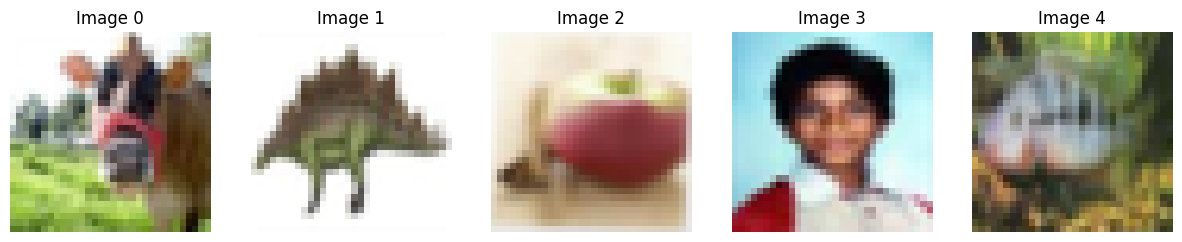

In [ ]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode="coarse")
    print(f"Training images shape: {train_images.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Testing images shape: {test_images.shape}")
    print(f"Testing labels shape: {test_labels.shape}")
    return train_images, train_labels, test_images, test_labels
train_images, train_labels, test_images, test_labels =load_data()
image_indices_to_visualize = [0, 1, 2, 3, 4]
plt.figure(figsize=(15, 3))
for i, image_index in enumerate(image_indices_to_visualize, 1):
    plt.subplot(1, 5, i)
    image = train_images[image_index, :, :, :]
    plt.imshow(image)
    plt.title(f"Image {image_index}")
    plt.axis('off')  # Turn off axis labels for clarity

plt.show()

##### Data pre-processing and augementation
Data normalization is applied to ensure all features are in similar scale. This ensures stability and accelerates convergence in the CNN while preventing it from getting trapped in the local optimum. They are then split into validation and training set in the ratio of 80 to 20% respectively. The images were then augemented through rotation, flipping and shifting to improve generalization and prevent overfitting.

In [ ]:
def pre_process(train_images, train_labels, test_images, test_labels):
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    #Convert labels to one hot coded suitable to ease calculation of categorical crossentropy Loss
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    return train_images, train_labels, test_images, test_labels

def data_stream(data,label):

    # Split the data into training and validation sets
    train_data, validation_data, train_label, validation_label = train_test_split(
        data, label, test_size=0.2, random_state=42
    )


    datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False
            )

    datagen.fit(train_data)
    train_data_gen = datagen.flow(train_data, train_label, batch_size=40)
    validation_data_gen = datagen.flow(validation_data, validation_label, batch_size=40)


    return train_data_gen,validation_data_gen



##### Define model
The CNN model served as the foundation, employing convolution layers for feature extraction. The Rectified Linear Unit (ReLU) activation function was applied to introduce non-linearity. Max pooling layers were utilized to downsample spatial dimensions, reducing computational complexity. To counter overfitting and enhance regularization, dropout layers were incorporated. These layers randomly deactivate a fraction of neurons during training, preventing the model from relying too heavily on specific features. Additionally, a flattening layer was employed to transform the multidimensional data into a one-dimensional format before feeding it into the fully connected layer.

In [ ]:
def cnn_model():
    model = Sequential()


    model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(20))
    model.add(Activation('softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, decay = 1e-6),
                  metrics=['accuracy'])

    # model.summary()
    return model


##### Train CNN


In [ ]:
x_train_samples = 50000
x_test_samples = 10000
train_images, train_labels, test_images, test_labels=load_data()
train_images, train_labels, test_images, test_labels = pre_process(train_images[0:x_train_samples], train_labels[0:x_train_samples], test_images[0:x_test_samples], test_labels[0:x_test_samples])
rounded_labels=np.argmax(test_labels, axis=1)



model = cnn_model()

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights = True)
start_time = time.time()
train_data_gen,validation_data_gen=data_stream(train_images,train_labels)
history = model.fit(train_data_gen,
                       steps_per_epoch=None,
                       epochs=20,
                       validation_data=validation_data_gen,
                       validation_steps=None,
                       verbose=1,
                       callbacks=[early_stop]
                       )
training_time = time.time() - start_time

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)
Epoch 1/20
1000/1000 [==============================] - 34s 33ms/step - loss: 2.6759 - accuracy: 0.1600 - val_loss: 2.5544 - val_accuracy: 0.2198
Epoch 2/20
1000/1000 [==============================] - 32s 32ms/step - loss: 2.3225 - accuracy: 0.2783 - val_loss: 2.3014 - val_accuracy: 0.3017
Epoch 3/20
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1205 - accuracy: 0.3377 - val_loss: 2.1311 - val_accuracy: 0.3461
Epoch 4/20
1000/1000 [==============================] - 32s 32ms/step - loss: 1.9811 - accuracy: 0.3792 - val_loss: 2.0102 - val_accuracy: 0.3857
Epoch 5/20
1000/1000 [==============================] - 32s 32ms/step - loss: 1.8566 - accuracy: 0.4164 - val_loss: 1.8430 - val_accuracy: 0.4319
Epoch 6/20
1000/1000 [==============================] - 32s 32ms/step - loss: 1.7579 - accuracy: 0.4492 - val_loss: 1.77

##### Predict test data

In [ ]:

start_time = time.time()
y_predicted = np.argmax(model.predict(test_images[0:x_test_samples]), axis=1)
inference_time = time.time() - start_time

313/313 [==============================] - 2s 6ms/step


##### Compute metrics

Accuracy: 65.10%
Precision: 66.58%
Recall (Sensitivity): 65.10%
F1 Score: 65.33%
Training Time: 651.11 seconds
Inference Time: 2.6241 seconds


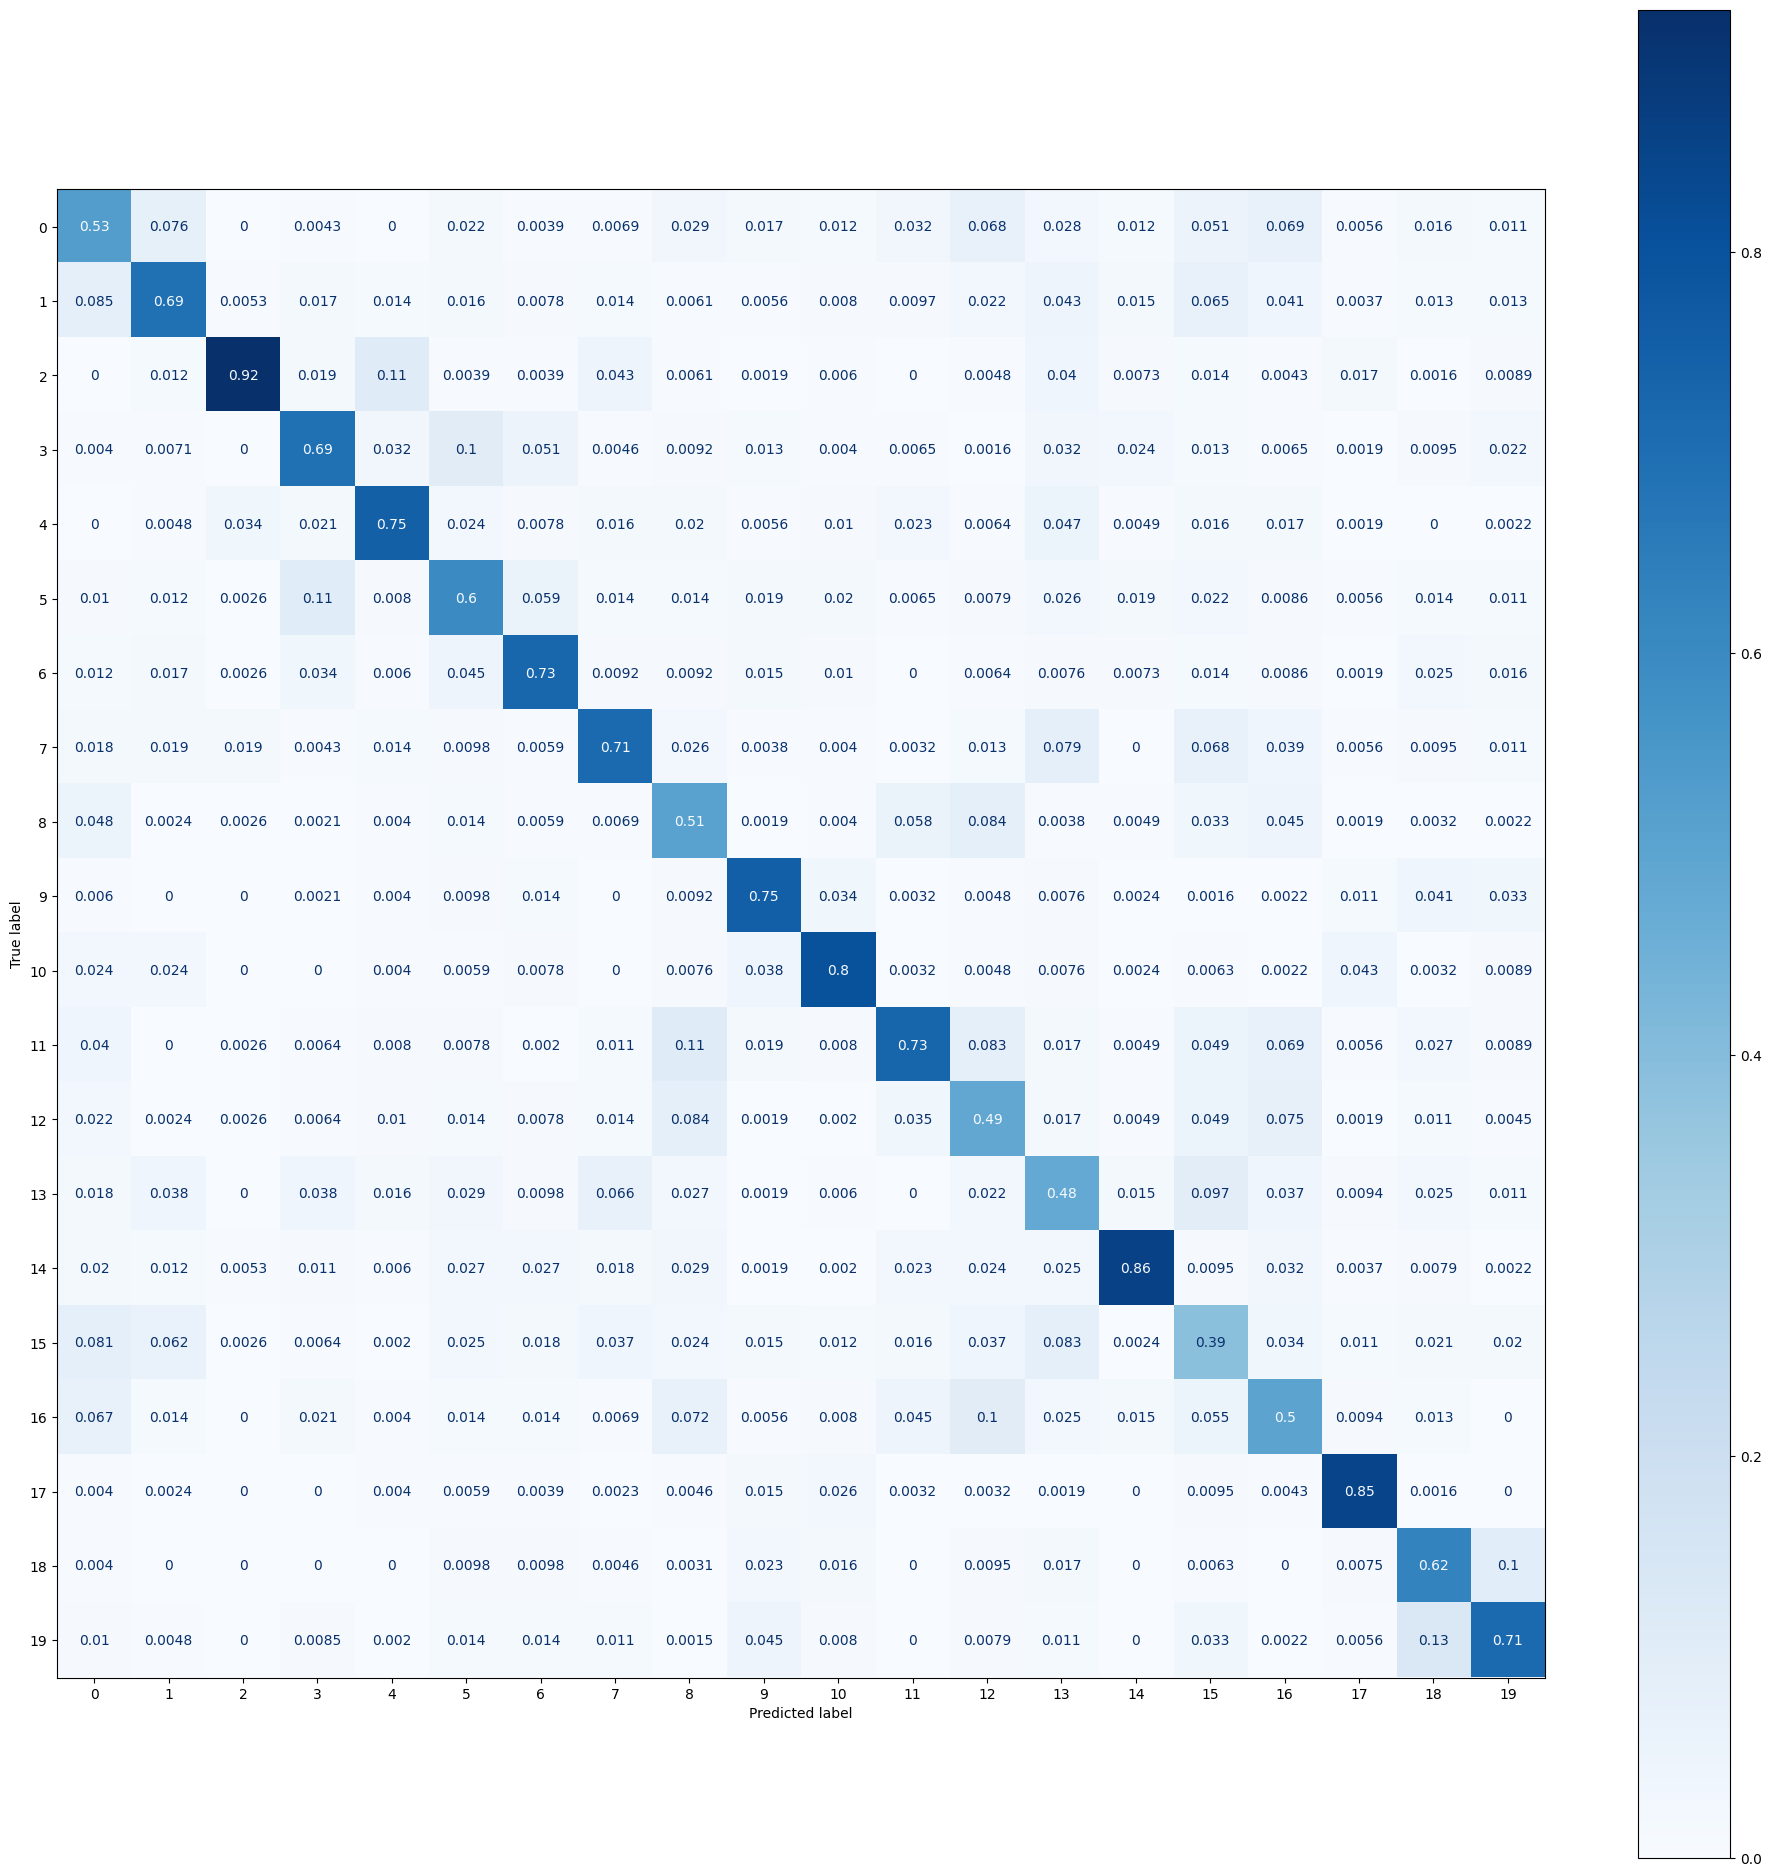

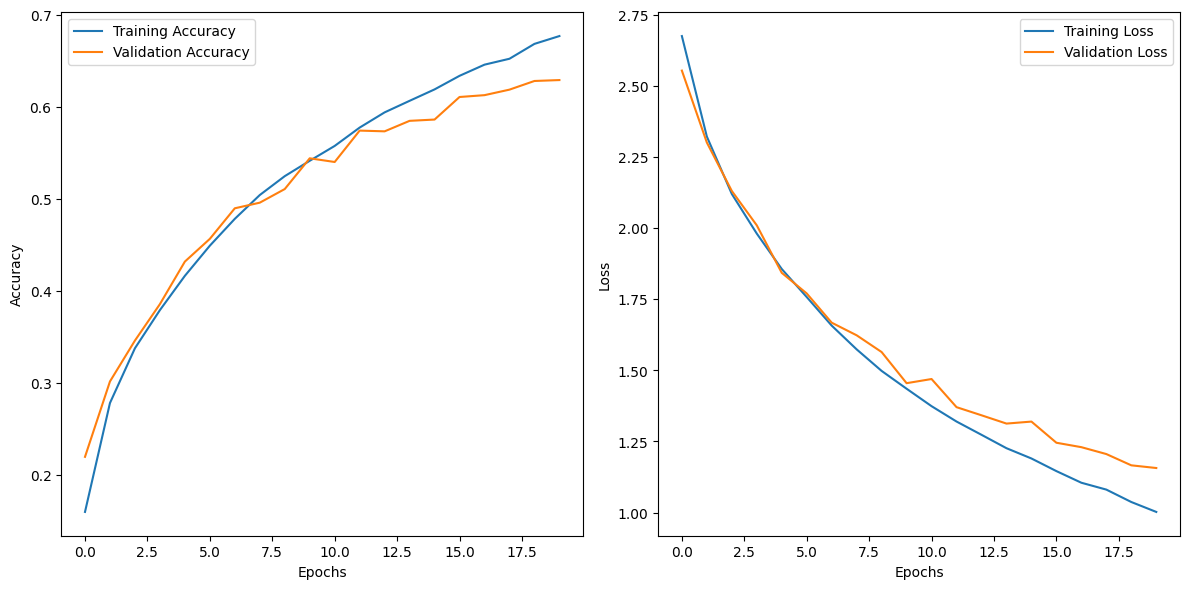

In [ ]:
def model_stats(history):
    plt.figure(figsize=(12, 6))
    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_conf_matrix(y1,y2):
    cm = confusion_matrix(y1, y2 , normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(24,24))
    disp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()

def print_metrics(y1,y2):
    # Accuracy
    accuracy = accuracy_score(y1, y2)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Precision
    precision = precision_score(y1, y2, average='macro', zero_division=1)
    print(f'Precision: {precision * 100:.2f}%')

    # Recall (Sensitivity)
    recall = recall_score(y1, y2, average='macro')
    print(f'Recall (Sensitivity): {recall * 100:.2f}%')

    # F1 Score
    f1 = f1_score(y1, y2, average='macro')
    print(f'F1 Score: {f1 * 100:.2f}%')


def print_time(training_time,inference_time):
   # Training Time
    print(f'Training Time: {training_time:.2f} seconds')

    # Inference Time
    print(f'Inference Time: {inference_time:.4f} seconds')

print_metrics(rounded_labels,y_predicted)
print_time(training_time,inference_time)
print_conf_matrix(rounded_labels,y_predicted)
model_stats(history)